In [2]:
import yfinance as yf
import pandas as pd

symbol = 'AAPL'
stock = yf.Ticker(symbol)

# save to json
# stock.balance_sheet.to_json(f"{symbol}_balance_sheet.json")
# stock.financials.to_json(f"{symbol}_income_statement.json")
# stock.cashflow.to_json(f"{symbol}_cash_flow.json")

balance_sheet = stock.balance_sheet
income_statement = stock.financials
cash_flow = stock.cashflow

print("Balance Sheet:")
print(balance_sheet)

print("\nIncome Statement:")
print(income_statement)

print("\nCash Flow Statement:")
print(cash_flow)

Balance Sheet:
                                                    2025-09-30    2024-09-30  \
Treasury Shares Number                                     NaN           NaN   
Ordinary Shares Number                            1.477326e+10  1.511679e+10   
Share Issued                                      1.477326e+10  1.511679e+10   
Net Debt                                          6.272300e+10  7.668600e+10   
Total Debt                                        9.865700e+10  1.066290e+11   
...                                                        ...           ...   
Cash Cash Equivalents And Short Term Investments  5.469700e+10  6.517100e+10   
Other Short Term Investments                      1.876300e+10  3.522800e+10   
Cash And Cash Equivalents                         3.593400e+10  2.994300e+10   
Cash Equivalents                                  7.667000e+09  2.744000e+09   
Cash Financial                                    2.826700e+10  2.719900e+10   

                        

# Altman Z-Score
Z=1.2×Working Capital+1.4×Retained Earnings+3.3×EBIT+0.6×Market Value of Equity+1.0×Total Assets

Working Capital: Current Assets - Current Liabilities
Indicates liquidity.

Retained Earnings: Total Equity - Common Stock
Reflects the cumulative profit retained for reinvestment.

EBIT (Earnings Before Interest and Taxes): Operating Income
Shows a company's profitability.

Market Value of Equity: Number of Shares Outstanding × Market Price per Share
Represents the company's value in the market.

Total Assets: Sum of all current and non-current assets
Measures the total resources owned by the company.



In [3]:
#check if col has nan val > 10, then drop col
balance_sheet = balance_sheet.dropna(axis=1, thresh=len(balance_sheet) - 10)
income_statement = income_statement.dropna(axis=1, thresh=len(income_statement) - 10)
cash_flow = cash_flow.dropna(axis=1, thresh=len(cash_flow) - 10)
balance_sheet

,2025-09-30,2024-09-30,2023-09-30,2022-09-30
Treasury Shares Number,NaN,NaN,0.000000e+00,NaN
Ordinary Shares Number,1.477326e+10,1.511679e+10,1.555006e+10,1.594342e+10
Share Issued,1.477326e+10,1.511679e+10,1.555006e+10,1.594342e+10
Net Debt,6.272300e+10,7.668600e+10,8.112300e+10,9.642300e+10
Total Debt,9.865700e+10,1.066290e+11,1.110880e+11,1.324800e+11
...,...,...,...,...
Cash Cash Equivalents And Short Term Investments,5.469700e+10,6.517100e+10,6.155500e+10,4.830400e+10
Other Short Term Investments,1.876300e+10,3.522800e+10,3.159000e+10,2.465800e+10
Cash And Cash Equivalents,3.593400e+10,2.994300e+10,2.996500e+10,2.364600e+10
Cash Equivalents,7.667000e+09,2.744000e+09,1.606000e+09,5.100000e+09


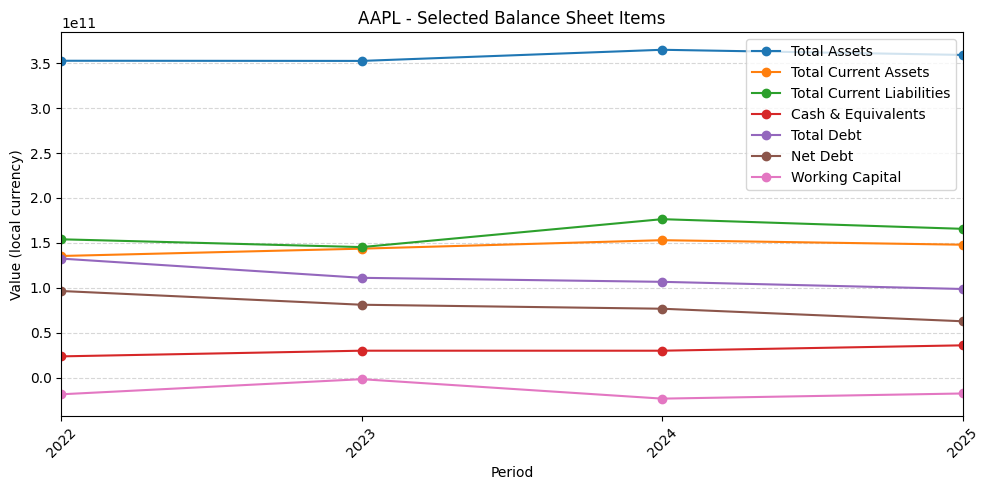

In [7]:
import matplotlib.pyplot as plt

# pick common balance-sheet line items (try several name variants)
metric_map = {
    'Total Assets': ['Total Assets', 'Total assets', 'TotalAssets'],
    'Total Current Assets': ['Total Current Assets', 'Current Assets', 'TotalCurrentAssets'],
    'Total Current Liabilities': ['Total Current Liabilities', 'Current Liabilities', 'TotalCurrentLiabilities'],
    'Cash & Equivalents': ['Cash And Cash Equivalents', 'Cash Cash Equivalents And Short Term Investments', 'Cash Equivalents', 'Cash Financial'],
    'Total Debt': ['Total Debt', 'TotalDebt', 'Total Liab', 'Total Liabilities'],
    'Net Debt': ['Net Debt'],
    'Working Capital': ['Working Capital', 'WorkingCapital']
}

def find_series(df, names):
    for n in names:
        if n in df.index:
            return df.loc[n]
    return None

# build plotting DataFrame (index = dates)
plot_dict = {}
for label, names in metric_map.items():
    s = find_series(balance_sheet, names)
    if s is not None:
        plot_dict[label] = s

if not plot_dict:
    print("No matching balance-sheet items found to plot.")
else:
    df_plot = pd.DataFrame(plot_dict)
    # ensure datetime index and sort chronologically
    df_plot.index = pd.to_datetime(df_plot.index)
    df_plot = df_plot.sort_index()

    # drop columns that are all-NaN
    df_plot = df_plot.dropna(axis=1, how='all')

    ax = df_plot.plot(marker='o', figsize=(10,5))
    ax.set_title(f"{symbol} - Selected Balance Sheet Items")
    ax.set_xlabel("Period")
    ax.set_ylabel("Value (local currency)")
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [4]:
# Altman Z-Score
# X-Score > 0: The company is classified as "distressed" (high probability of failure).
# X-Score < 0: The company is classified as "stable."
# Altman Z-Score (process a single statement/period; loop over periods will be done later)
def altman_z_score_for_period(balance_sheet, income_statement, cash_flow, col):
    # helper: return first available metric value for given column
    def get(df, names):
        for n in names:
            if n in df.index and col in df.columns:
                val = df.loc[n, col]
                if pd.notna(val):
                    return float(val)
        return None

    total_assets = get(balance_sheet, ['Total Assets', 'Total assets', 'TotalAssets'])
    total_liabilities = get(balance_sheet, [
        'Total Liabilities Net Minority Interest', 'Total Liab', 'Total Liabilities', 'Total liabilities'
    ])

    # working capital: prefer explicit field, else CA - CL
    working_capital = get(balance_sheet, ['Working Capital', 'WorkingCapital'])
    if working_capital is None:
        ca = get(balance_sheet, ['Total Current Assets', 'Current Assets', 'TotalCurrentAssets'])
        cl = get(balance_sheet, ['Total Current Liabilities', 'Current Liabilities', 'TotalCurrentLiabilities'])
        if ca is not None and cl is not None:
            working_capital = ca - cl

    retained_earnings = get(balance_sheet, ['Retained Earnings', 'RetainedEarnings'])

    # EBIT / Operating Income
    ebit = get(income_statement, ['Ebit', 'EBIT', 'Operating Income', 'OperatingIncome'])

    # market cap: use ticker fast_info/info (not period-specific)
    try:
        market_value_equity = stock.fast_info.get('market_cap', None)
    except Exception:
        market_value_equity = None
    if market_value_equity is None:
        market_value_equity = stock.info.get('marketCap', None)

    sales = get(income_statement, ['Total Revenue', 'Revenue', 'Sales', 'TotalRevenue'])

    # basic validation
    if total_assets in (None, 0):
        return float('nan')
    if total_liabilities in (None, 0):
        # allow D to be 0 if liabilities missing, but avoid division by zero
        D = 0.0
    else:
        D = (market_value_equity or 0.0) / total_liabilities

    A = (working_capital or 0.0) / total_assets
    B = (retained_earnings or 0.0) / total_assets
    C = (ebit or 0.0) / total_assets
    E = (sales or 0.0) / total_assets

    z_score = 1.2 * A + 1.4 * B + 3.3 * C + 0.6 * D + 1.0 * E
    return z_score

# compute a single z_score for the most recent column (keeps compatibility with downstream cells)
z_scores = []
for col in balance_sheet.columns:
    z = altman_z_score_for_period(balance_sheet, income_statement, cash_flow, col)
    z_scores.append((col, z))
    print(f"Altman Z-Score for period {col.date()}: {z:.4f}")



Altman Z-Score for period 2025-09-30: 10.7419
Altman Z-Score for period 2024-09-30: 9.8912
Altman Z-Score for period 2023-09-30: 10.4821
Altman Z-Score for period 2022-09-30: 10.1706


In [5]:
# start = earliest date from financial statements 
start_date = balance_sheet.columns.min().date().isoformat()

end_date = "2025-10-31"

# Date df
date_range = pd.date_range(start=start_date, end=end_date, freq='B')
date_df = pd.DataFrame(date_range, columns=['Date'])
date_df
# zscore df
zscore_df = pd.DataFrame(z_scores, columns=['Date', 'ZSCORE'])
zscore_df['Date'] = pd.to_datetime(zscore_df['Date'])

zscore_df

,Date,ZSCORE
0,2025-09-30,10.741872
1,2024-09-30,9.891161
2,2023-09-30,10.482106
3,2022-09-30,10.170596


In [6]:
# export df to csv
zscore_df.to_csv('fundamental_zscore.csv', index=False)